# Introduction

Compare count matrices generated by different single cell mappers or pseudomappers.

<table>
    <thead>
        <tr><td>Algorithm</td><td>Comment</td></tr>
    </thead>
    <tbody>
        <tr><td>Cellranger</td><td></td></tr>
        <tr><td>STAR Solo</td><td></td></tr>
        <tr><td>Alevin</td><td></td></tr>
        <tr><td>Kallisto</td><td></td></tr>
        <tr><td>Kallisto EM</td><td>Kallisto bustools count withe --em flag</td></tr>
    </tbody>
</table>

In [1]:
import numpy
import scanpy
import anndata
import os
import pandas
from matplotlib import pyplot
import scipy
from pathlib import Path
import upsetplot
import louvain
import sklearn
import seaborn

from pipeline_common import get_gene_id_to_name, load_gtf
#from cuml.decomposition import PCA
#from cuml.manifold import TSNE


In [2]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline'

In [3]:
analysis_dir = Path('ENCSR874BOF_e10_5_limb')

# Datasets available

In [4]:
ls $analysis_dir/*.h5ad

ENCSR874BOF_e10_5_limb/alevin_diff_filtered.h5ad
ENCSR874BOF_e10_5_limb/alevin_filtered.h5ad
ENCSR874BOF_e10_5_limb/cellranger_diff_filtered.sparse.h5ad
ENCSR874BOF_e10_5_limb/cellranger_filtered.sparse.h5ad
ENCSR874BOF_e10_5_limb/kallisto_em_filtered.h5ad
ENCSR874BOF_e10_5_limb/kallisto_filtered.h5ad
ENCSR874BOF_e10_5_limb/solo_filtered.sparse.h5ad


In [5]:
scanpy.__version__

'1.4.5.1'

In [6]:
gene_id_name = get_gene_id_to_name('mm10-M21-male')

In [7]:
M21_gtf = load_gtf('mm10-M21-male')

## Load data into scanpy

In [8]:
cellr_common = scanpy.read_h5ad(analysis_dir / 'cellranger_filtered.sparse.h5ad')
cellr_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols', 'feature_types'

In [9]:
solo_common = scanpy.read_h5ad(analysis_dir / 'solo_filtered.sparse.h5ad')
solo_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols'

In [10]:
alevin_common = scanpy.read_h5ad(analysis_dir / 'alevin_filtered.h5ad')
alevin_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols'

In [11]:
kallisto_common = scanpy.read_h5ad(analysis_dir / 'kallisto_filtered.h5ad')
kallisto_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols'

In [12]:
kallisto_em_common = scanpy.read_h5ad(analysis_dir / 'kallisto_em_filtered.h5ad')
kallisto_em_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols'

In [13]:
cellr_common.var_keys()

['gene_symbols', 'feature_types']

## Load Diff sets

In [14]:
cellr_diff = scanpy.read_h5ad(analysis_dir / 'cellranger_diff_filtered.sparse.h5ad')
cellr_diff

AnnData object with n_obs × n_vars = 916 × 81881 
    var: 'gene_symbols', 'feature_types'

In [15]:
alevin_diff = scanpy.read_h5ad(analysis_dir / 'alevin_diff_filtered.h5ad')
alevin_diff

AnnData object with n_obs × n_vars = 1015 × 81881 
    var: 'gene_symbols'

## Basic QC

Do all the names match?

In [16]:
assert numpy.all(cellr_common.obs_names == solo_common.obs_names)
assert numpy.all(cellr_common.obs_names == alevin_common.obs_names)
assert numpy.all(cellr_common.obs_names == kallisto_common.obs_names)
assert numpy.all(cellr_common.obs_names == kallisto_em_common.obs_names)

In [17]:
assert numpy.all(cellr_common.var_names == solo_common.var_names)
assert numpy.all(cellr_common.var_names == alevin_common.var_names)
assert numpy.all(cellr_common.var_names == kallisto_common.var_names)
assert numpy.all(cellr_common.var_names == kallisto_em_common.var_names)

# Plot basic scanpy single cell QC

Compare gene by count, total count and percent mitochondiral genes (located on chrM)

In [18]:
mt_gene_ids = M21_gtf[(M21_gtf.chromosome == 'chrM') & (M21_gtf.type == 'gene')]['gene_id'].values

In [19]:
# Label mitochondrial genes
cellr_common.var['mt'] = cellr_common.var_names.isin(mt_gene_ids)
solo_common.var['mt'] = solo_common.var_names.isin(mt_gene_ids)
alevin_common.var['mt'] = alevin_common.var_names.isin(mt_gene_ids)
kallisto_common.var['mt'] = kallisto_common.var_names.isin(mt_gene_ids)
kallisto_em_common.var['mt'] = kallisto_em_common.var_names.isin(mt_gene_ids)

In [20]:
cellr_diff.var['mt'] = cellr_diff.var_names.isin(mt_gene_ids)
alevin_diff.var['mt'] = alevin_diff.var_names.isin(mt_gene_ids)

## Cellranger common barcodes

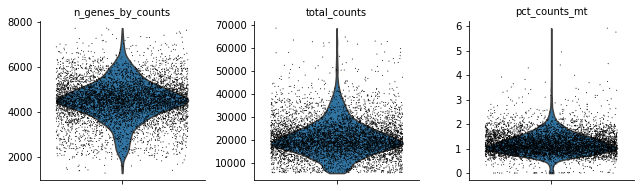

In [21]:
scanpy.pp.calculate_qc_metrics(cellr_common, qc_vars=['mt'], percent_top=None, inplace=True)
scanpy.pl.violin(cellr_common, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## STAR Solo common barcodes

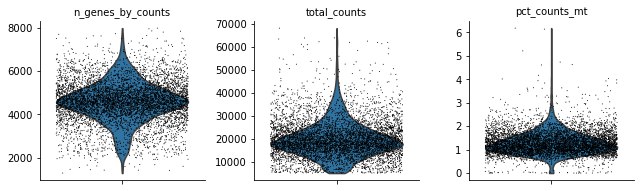

In [22]:
scanpy.pp.calculate_qc_metrics(solo_common, qc_vars=['mt'], percent_top=None, inplace=True)
scanpy.pl.violin(solo_common, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## Alevin common barcodes

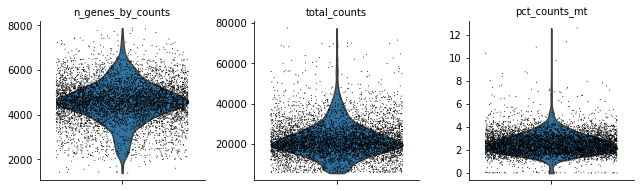

In [23]:
scanpy.pp.calculate_qc_metrics(alevin_common, qc_vars=['mt'], percent_top=None, inplace=True)
scanpy.pl.violin(alevin_common, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## Kallisto common barcodes

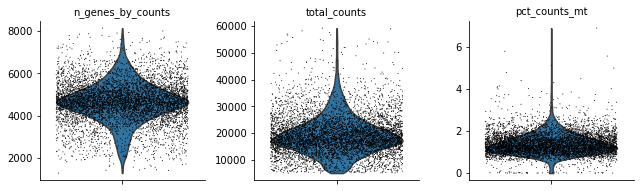

In [24]:
scanpy.pp.calculate_qc_metrics(kallisto_common, qc_vars=['mt'], percent_top=None, inplace=True)
scanpy.pl.violin(kallisto_common, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## Kalisto EM Common barcodes

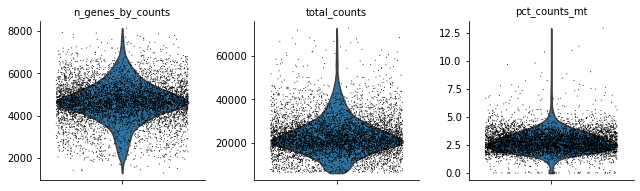

In [25]:
scanpy.pp.calculate_qc_metrics(kallisto_em_common, qc_vars=['mt'], percent_top=None, inplace=True)
scanpy.pl.violin(kallisto_em_common, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## Cellranger filters more cells (7202 vs. 6287). What's different?

Kallisto doesn't have a built in filter mode and so I can't compare this yet

In [26]:
upset_contents = upsetplot.from_contents({
    'cellranger': set(cellr_common.obs.index).union(cellr_diff.obs.index),
    'star solo': solo_common.obs.index,
    'alevin': set(alevin_common.obs.index).union(alevin_diff.obs.index),
})

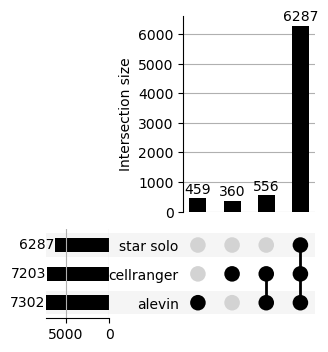

In [27]:
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_contents, fig=f, show_counts=True)

## Cellranger barcodes not found in STAR Solo

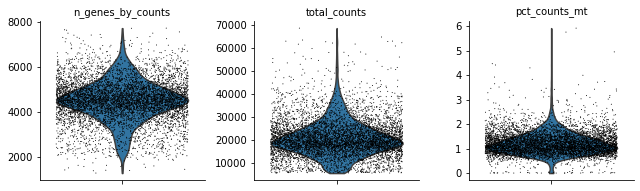

In [28]:
scanpy.pl.violin(cellr_common, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

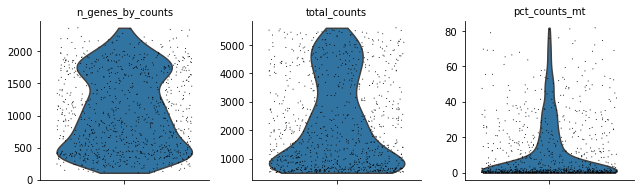

In [29]:
scanpy.pp.calculate_qc_metrics(cellr_diff, qc_vars=['mt'], percent_top=None, inplace=True)
scanpy.pl.violin(cellr_diff, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

# Alevin barcodes not found in STAR Solo

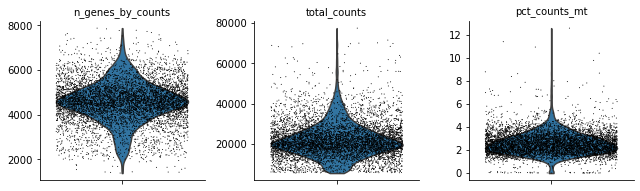

In [30]:
scanpy.pl.violin(alevin_common, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

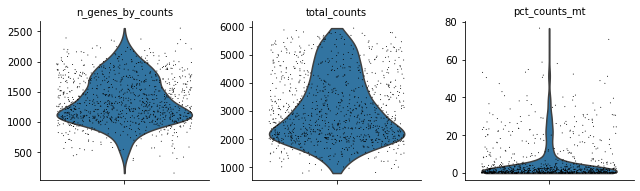

In [31]:
scanpy.pp.calculate_qc_metrics(alevin_diff, qc_vars=['mt'], percent_top=None, inplace=True)
scanpy.pl.violin(alevin_diff, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

# Correlation between count matrices

In [32]:
dense_mat = {
    'cellranger': numpy.array(cellr_common.X.todense()),
    'solo': numpy.array(solo_common.X.todense()),
    'alevin': numpy.array(alevin_common.X.todense()),
    'kallisto': numpy.array(kallisto_common.X.todense()),
    'kallisto EM': numpy.array(kallisto_em_common.X.todense()),
}

## Corelation between sum accross all cells by program

In [33]:
programs = list(dense_mat.keys())
population_correlation = {}

for name_x in programs:
    for name_y in programs[programs.index(name_x):]:
        corrcoef = numpy.corrcoef(dense_mat[name_x].sum(axis=1), dense_mat[name_y].sum(axis=1))
        population_correlation.setdefault(name_x, {})[name_y] = corrcoef[0][1]
        
population_correlation = pandas.DataFrame(population_correlation)

In [34]:
population_correlation

,cellranger,solo,alevin,kallisto,kallisto EM
cellranger,1.000000,NaN,NaN,NaN,NaN
solo,0.999636,1.000000,NaN,NaN,NaN
alevin,0.999369,0.998958,1.000000,NaN,NaN
kallisto,0.998161,0.998396,0.996918,1.000000,NaN
kallisto EM,0.999084,0.998485,0.998651,0.998658,1.0


### Shared functions for calculating correlations

In [35]:
def correlate_matricies_pearson(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    cs_cors=[]
    for i in range(left.shape[1]):
        cs_cors.append(numpy.corrcoef(left[:,i], right[:,i])[0,1])
    cs_cors = numpy.array(cs_cors)[~numpy.isnan(cs_cors)]
    #print('Len', len(cs_cors))
    #print('Mean', numpy.mean(cs_cors))
    #print('Median', numpy.median(cs_cors))
    return cs_cors

In [36]:
def correlate_matricies_spearman(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    cs_cors=[]
    for i in range(left.shape[1]):
        cs_cors.append(scipy.stats.spearmanr(left[:,i], right[:,i])[0])
    cs_cors = numpy.array(cs_cors)[~numpy.isnan(cs_cors)]
    #print('Len', len(cs_cors))
    #print('Mean', numpy.mean(cs_cors))
    #print('Median', numpy.median(cs_cors))
    return cs_cors

In [37]:
def apply_summary_function(table, function):
    programs = list(table.keys())
    summary = {}
    for name_x in programs:
        for name_y in programs[programs.index(name_x)+1:]:
            summary.setdefault(name_x, {})[name_y] = function(table[name_x][name_y])
        
    return pandas.DataFrame(summary)


compute pearson correlation between barcodes in the dense matricies

In [38]:
programs = list(dense_mat.keys())
cell_correlations = {}

for name_x in programs:
    for name_y in programs[programs.index(name_x):]:
        cs_cors = correlate_matricies_pearson(dense_mat[name_x], dense_mat[name_y])
        cell_correlations.setdefault(name_x, {})[name_y] = cs_cors


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## Length of Pearson correlations that could be calculated

In [39]:
apply_summary_function(cell_correlations, len)

,cellranger,solo,alevin,kallisto
solo,24671,NaN,NaN,NaN
alevin,24013,24237.0,NaN,NaN
kallisto,24260,24550.0,23981.0,NaN
kallisto EM,24260,24550.0,23981.0,38269.0


## Mean cell Pearson correlations

In [40]:
apply_summary_function(cell_correlations, numpy.mean)

,cellranger,solo,alevin,kallisto
solo,0.936684,NaN,NaN,NaN
alevin,0.900095,0.915253,NaN,NaN
kallisto,0.762685,0.743838,0.74275,NaN
kallisto EM,0.761729,0.742497,0.74386,0.995119


## Median cell Pearson correlations

In [41]:
apply_summary_function(cell_correlations, numpy.median)

,cellranger,solo,alevin,kallisto
solo,0.984762,NaN,NaN,NaN
alevin,0.958853,0.973469,NaN,NaN
kallisto,0.920985,0.905478,0.886400,NaN
kallisto EM,0.918453,0.901759,0.885371,1.0


# Histogram of cell by cell correlations

In [42]:
def plot_cell_correlation_histogram(table):
    programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(7,7))
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True)
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            #if plot_index >= 13:
            #    ax.set_xlabel(name_x)
            #ax.set_title(f'{name_x}/{name_y}/{x},{y},{plot_index}')
            median = numpy.median(table[name_x][name_y])
            mean = numpy.mean(table[name_x][name_y])
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(table[name_x][name_y], bins=50)
            ax.text(0, ax.get_yticks()[-2], f'Mean {mean:0.2}\nMedian {median:0.2}')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.tight_layout()

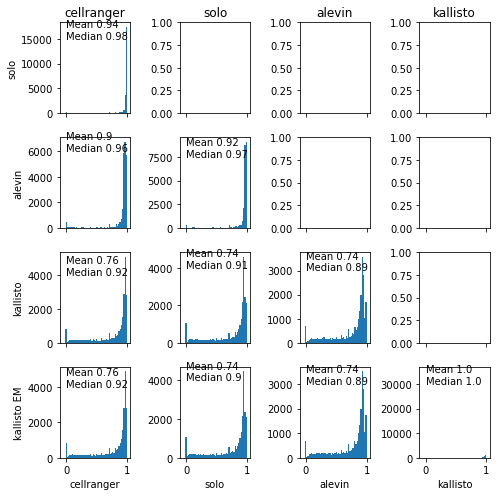

In [43]:
plot_cell_correlation_histogram(cell_correlations)

## Filter out genes with zero expression in all cells

In [44]:
scanpy.pp.filter_genes(cellr_common, min_cells=1)
cellr_common.shape

(6287, 24839)

In [45]:
scanpy.pp.filter_genes(solo_common, min_cells=1)
solo_common.shape

(6287, 25268)

In [46]:
scanpy.pp.filter_genes(alevin_common, min_cells=1)
alevin_common.shape

(6287, 24996)

In [47]:
scanpy.pp.filter_genes(kallisto_common, min_cells=1)
kallisto_common.shape

(6287, 38269)

In [48]:
scanpy.pp.filter_genes(kallisto_em_common, min_cells=1)
kallisto_em_common.shape

(6287, 38269)

In [49]:
non_zero_rows = pandas.DataFrame({
    'cellranger': [cellr_common.shape[1]],
    'solo': [solo_common.shape[1]],
    'alevin': [alevin_common.shape[1]],
    'kallisto': [kallisto_common.shape[1]],
    'kallisto EM': [kallisto_em_common.shape[1]],
}, index=['non-zero rows']).T

In [50]:
non_zero_rows

,non-zero rows
cellranger,24839
solo,25268
alevin,24996
kallisto,38269
kallisto EM,38269


## Preprocess count matrices

In [51]:
# Normalize
scanpy.pp.normalize_total(cellr_common, target_sum=1e4)
scanpy.pp.log1p(cellr_common)

# Filter variable genes
scanpy.pp.highly_variable_genes(cellr_common, n_top_genes=5000, flavor="cell_ranger")
cellr_highly_variable = cellr_common[:, cellr_common.var.highly_variable]
scanpy.pp.scale(cellr_highly_variable, max_value=10)

/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:913: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [52]:
scanpy.pp.normalize_total(solo_common, target_sum=1e4)
scanpy.pp.log1p(solo_common)

scanpy.pp.highly_variable_genes(solo_common, n_top_genes=5000, flavor="cell_ranger")
solo_highly_variable = solo_common[:, solo_common.var.highly_variable]
scanpy.pp.scale(solo_highly_variable, max_value=10)

/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:913: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [53]:
scanpy.pp.normalize_total(alevin_common, target_sum=1e4)
scanpy.pp.log1p(alevin_common)

scanpy.pp.highly_variable_genes(alevin_common, n_top_genes=5000, flavor="cell_ranger")
alevin_highly_variable = alevin_common[:, alevin_common.var.highly_variable]
scanpy.pp.scale(alevin_highly_variable, max_value=10)

/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:913: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [54]:
scanpy.pp.normalize_total(kallisto_common, target_sum=1e4)
scanpy.pp.log1p(kallisto_common)

scanpy.pp.highly_variable_genes(kallisto_common, n_top_genes=5000, flavor="cell_ranger")
kallisto_highly_variable = kallisto_common[:, kallisto_common.var.highly_variable]
scanpy.pp.scale(kallisto_highly_variable, max_value=10)

/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:913: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [55]:
scanpy.pp.normalize_total(kallisto_em_common, target_sum=1e4)
scanpy.pp.log1p(kallisto_em_common)

scanpy.pp.highly_variable_genes(kallisto_em_common, n_top_genes=5000, flavor="cell_ranger")
kallisto_em_highly_variable = kallisto_em_common[:, kallisto_em_common.var.highly_variable]
scanpy.pp.scale(kallisto_em_highly_variable, max_value=10)

/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:913: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Dimension reduction

In [56]:
pca_method='umap'
#NVIDIA used 'rapids'

In [57]:
# PCA
#cellr_common.obsm["X_pca"] = PCA(n_components=50).fit_transform(cellr_common.X)
scanpy.tl.pca(cellr_common, n_comps=50)
# UMAP
scanpy.pp.neighbors(cellr_highly_variable, n_neighbors=20, n_pcs=50, method=pca_method)
scanpy.tl.umap(cellr_highly_variable, spread=1, min_dist=0.6, method=pca_method)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [58]:
# PCA
#solo_common.obsm["X_pca"] = PCA(n_components=50).fit_transform(solo_common.X)
scanpy.tl.pca(solo_common, n_comps=50)
# UMAP
scanpy.pp.neighbors(solo_highly_variable, n_neighbors=20, n_pcs=50, method=pca_method)
scanpy.tl.umap(solo_highly_variable, spread=1, min_dist=0.6, method=pca_method)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [59]:
# PCA
#alevin_common.obsm["X_pca"] = PCA(n_components=50).fit_transform(alevin_common.X)
scanpy.tl.pca(alevin_common, n_comps=50)
# UMAP
scanpy.pp.neighbors(alevin_highly_variable, n_neighbors=20, n_pcs=50, method=pca_method)
scanpy.tl.umap(alevin_highly_variable, spread=1, min_dist=0.6, method=pca_method)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [60]:
# PCA
#kallisto_common.obsm["X_pca"] = PCA(n_components=50).fit_transform(kallisto_common.X)
scanpy.tl.pca(kallisto_common, n_comps=50)
# UMAP
scanpy.pp.neighbors(kallisto_highly_variable, n_neighbors=20, n_pcs=50, method=pca_method)
scanpy.tl.umap(kallisto_highly_variable, spread=1, min_dist=0.6, method=pca_method)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [61]:
# PCA
#kallisto_em_common.obsm["X_pca"] = PCA(n_components=50).fit_transform(kallisto_common_em.X)
scanpy.tl.pca(kallisto_em_common, n_comps=50)
# UMAP
scanpy.pp.neighbors(kallisto_em_highly_variable, n_neighbors=20, n_pcs=50, method=pca_method)
scanpy.tl.umap(kallisto_em_highly_variable, spread=1, min_dist=0.6, method=pca_method)

         Falling back to preprocessing with `sc.pp.pca` and default params.


# Clustering

In [62]:
louvain_flavor='vtraag'
#NVIDIA used 'rapids'

## Louvain Cellranger

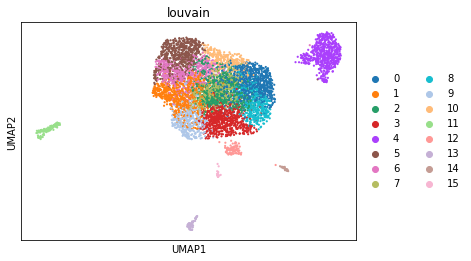

In [63]:
scanpy.tl.louvain(cellr_highly_variable, flavor=louvain_flavor)
scanpy.pl.umap(cellr_highly_variable, color=["louvain"])

## Louvain STAR Solo

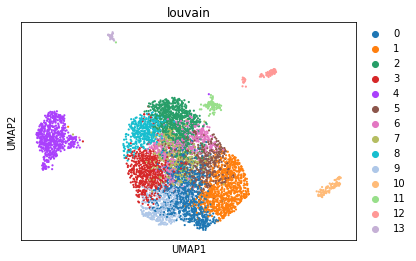

In [64]:
scanpy.tl.louvain(solo_highly_variable, flavor=louvain_flavor)
scanpy.pl.umap(solo_highly_variable, color=["louvain"])

## Louvain Alevin

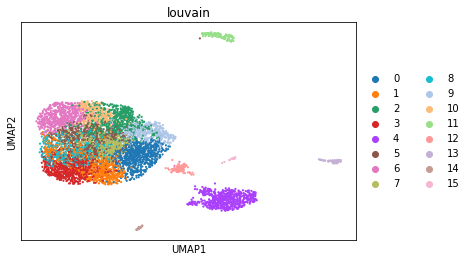

In [65]:
scanpy.tl.louvain(alevin_highly_variable, flavor=louvain_flavor)
scanpy.pl.umap(alevin_highly_variable, color=["louvain"])

## Louvain Kallisto

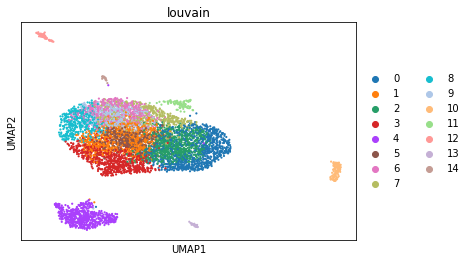

In [66]:
scanpy.tl.louvain(kallisto_highly_variable, flavor=louvain_flavor)
scanpy.pl.umap(kallisto_highly_variable, color=["louvain"])

## Louvain Kallisto EM

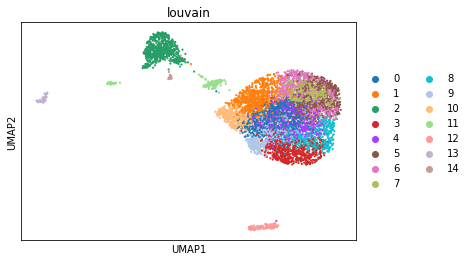

In [67]:
scanpy.tl.louvain(kallisto_em_highly_variable, flavor=louvain_flavor)
scanpy.pl.umap(kallisto_em_highly_variable, color=["louvain"])

## Leiden Cellranger

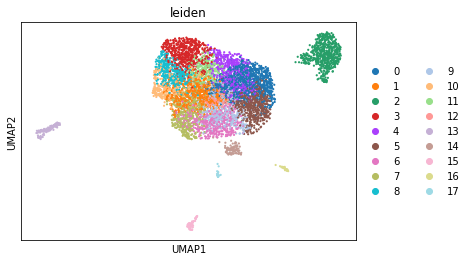

In [68]:
scanpy.tl.leiden(cellr_highly_variable)
scanpy.pl.umap(cellr_highly_variable, color=["leiden"])

## Leiden STAR Solor

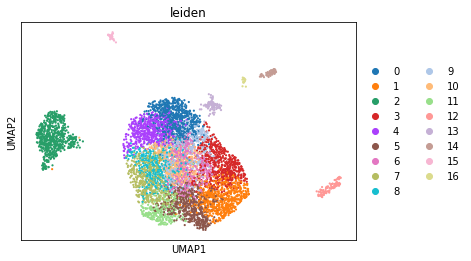

In [69]:
scanpy.tl.leiden(solo_highly_variable)
scanpy.pl.umap(solo_highly_variable, color=["leiden"])

## Leiden Alevin

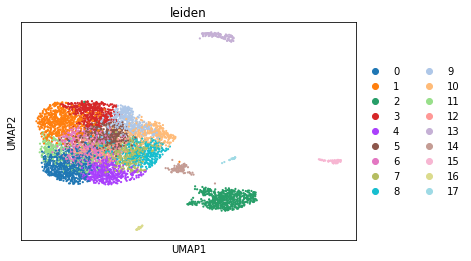

In [70]:
scanpy.tl.leiden(alevin_highly_variable)
scanpy.pl.umap(alevin_highly_variable, color=["leiden"])

## Leiden Kallisto

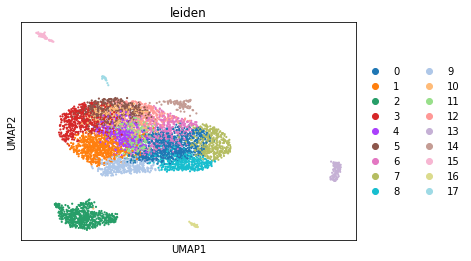

In [71]:
scanpy.tl.leiden(kallisto_highly_variable)
scanpy.pl.umap(kallisto_highly_variable, color=["leiden"])

## Leiden Kallisto EM

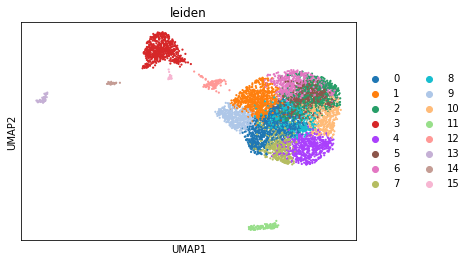

In [72]:
scanpy.tl.leiden(kallisto_em_highly_variable)
scanpy.pl.umap(kallisto_em_highly_variable, color=["leiden"])

## Compare cluster assignments from Cellranger and STARsolo

In [73]:
common_anndata = {
    'Cellranger': cellr_highly_variable,
    'STAR Solo': solo_highly_variable,
    'Alevin': alevin_highly_variable,
    'Kallisto': kallisto_highly_variable,
    'Kallisto EM': kallisto_em_highly_variable,
}

## Adjusted Rand Score Leiden Clustering

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score">sklearn adjusted rand score</a>

In [74]:
def calculate_rand_score(method, common_anndata):
    programs = list(common_anndata.keys())
    rand_score = {}
    for name_x in programs:
        for name_y in programs[programs.index(name_x)+1:]:
            rand_score.setdefault(name_x, {})[name_y] = sklearn.metrics.adjusted_rand_score(
                common_anndata[name_x].obs[method], 
                common_anndata[name_y].obs[method])

    return pandas.DataFrame(rand_score)

In [75]:
calculate_rand_score('leiden', common_anndata)

,Cellranger,STAR Solo,Alevin,Kallisto
STAR Solo,0.573407,NaN,NaN,NaN
Alevin,0.624568,0.604229,NaN,NaN
Kallisto,0.466208,0.470849,0.497925,NaN
Kallisto EM,0.541354,0.466139,0.532679,0.58511


## Adjust rand score louvain

In [76]:
calculate_rand_score('louvain', common_anndata)

,Cellranger,STAR Solo,Alevin,Kallisto
STAR Solo,0.585595,NaN,NaN,NaN
Alevin,0.566113,0.505430,NaN,NaN
Kallisto,0.429395,0.424069,0.424487,NaN
Kallisto EM,0.450144,0.481456,0.520209,0.427296


## Adjusted Mutual Information Score Leiden Clustering

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score">Adjusted Mutual Information Score</a>

In [77]:
def calculate_adjusted_mutual(method, common_anndata):
    programs = list(common_anndata.keys())
    ami = {}
    for name_x in programs:
        for name_y in programs[programs.index(name_x)+1:]:
            ami.setdefault(name_x, {})[name_y] = sklearn.metrics.adjusted_mutual_info_score(
                common_anndata[name_x].obs[method],
                common_anndata[name_y].obs[method])


    return pandas.DataFrame(ami)


In [78]:
calculate_adjusted_mutual('leiden', common_anndata)

,Cellranger,STAR Solo,Alevin,Kallisto
STAR Solo,0.710795,NaN,NaN,NaN
Alevin,0.733297,0.715396,NaN,NaN
Kallisto,0.649566,0.635137,0.654244,NaN
Kallisto EM,0.670654,0.627271,0.669493,0.704821


## Adjusted Mutual Information Louvain

In [79]:
calculate_adjusted_mutual('louvain', common_anndata)

,Cellranger,STAR Solo,Alevin,Kallisto
STAR Solo,0.681941,NaN,NaN,NaN
Alevin,0.682379,0.647923,NaN,NaN
Kallisto,0.606536,0.600890,0.606035,NaN
Kallisto EM,0.613432,0.633080,0.649035,0.610941


## Simple confusion matrices

In [80]:
def confusion(clustering_name, a, b):
    cm = {}
    
    for a_cluster in a.obs[clustering_name].cat.categories:
        for b_cluster in b.obs[clustering_name].cat.categories:
            cm.setdefault(a_cluster, {}).setdefault(b_cluster, 0)
            
    for a_barcode, a_cluster in a.obs[clustering_name].iteritems():
        b_cluster = b.obs[clustering_name][a_barcode]
        cm[a_cluster][b_cluster] += 1

    return pandas.DataFrame(cm, dtype=int)

def plot_confusion(clustering_name, common_anndata, a_label, b_label, title=None):
    cm = confusion(clustering_name, common_anndata[a_label], common_anndata[b_label])
    f = pyplot.figure(figsize=(9,9))
    ax = f.subplots()
    _ = seaborn.heatmap(cm, annot=True, fmt="d", ax=ax)
    ax.set_xlabel(a_label)
    ax.set_ylabel(b_label)
    if title is not None:
        ax.set_title(title)    
    

## Cellranger vs STAR Solor Leiden confusion matrix

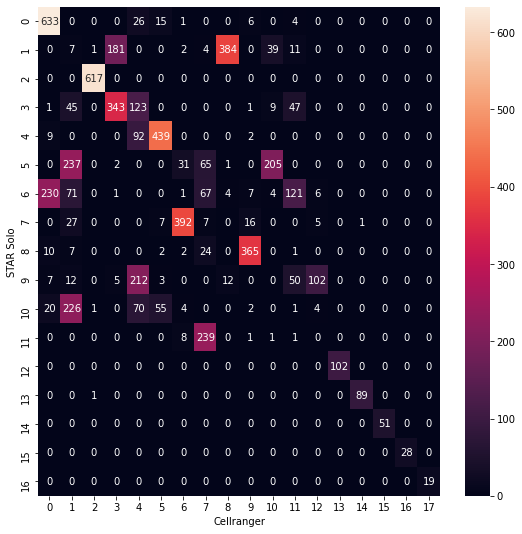

In [81]:
plot_confusion('leiden', common_anndata, 'Cellranger', 'STAR Solo')

## Leiden Cellranger vs Alevin confusion matrix

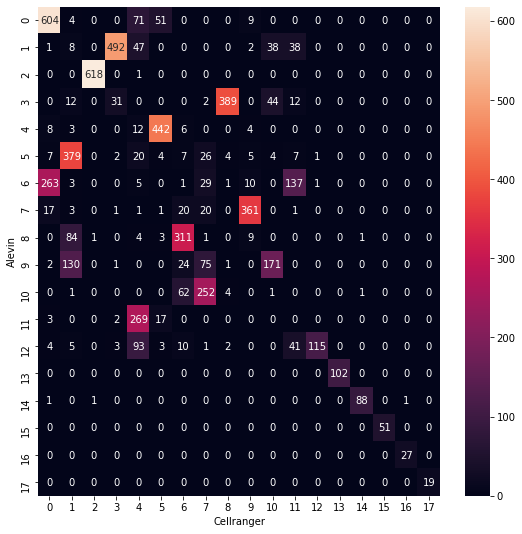

In [82]:
plot_confusion('leiden', common_anndata, 'Cellranger', 'Alevin')

## Leiden Cellranger vs Kallisto confusion matrix

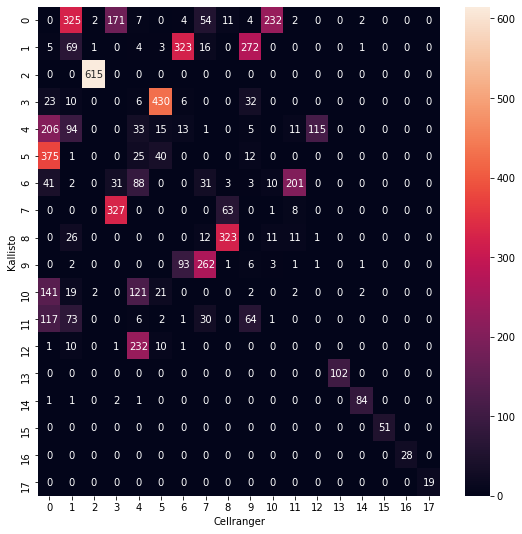

In [83]:
plot_confusion('leiden', common_anndata, 'Cellranger', 'Kallisto')

## Leiden Cellranger vs Kallisto EM confusion matrix

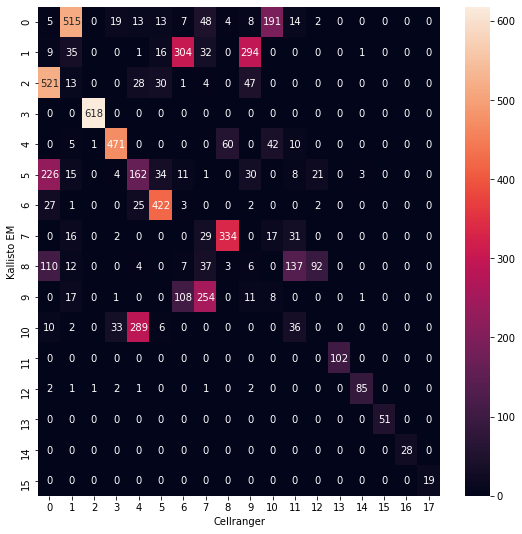

In [84]:
plot_confusion('leiden', common_anndata, 'Cellranger', 'Kallisto EM')

## Leiden STAR Solo vs Alevin confusion matrix

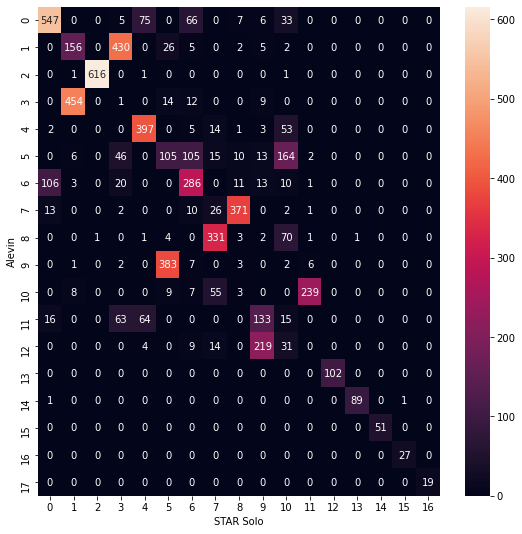

In [85]:
plot_confusion('leiden', common_anndata, 'STAR Solo', 'Alevin')

## Leiden STAR Solo vs Kallisto confusion matrix

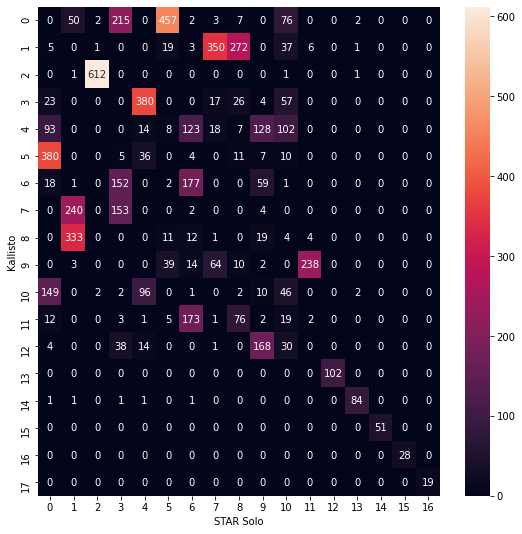

In [86]:
plot_confusion('leiden', common_anndata, 'STAR Solo', 'Kallisto')

## Leiden STAR Solo vs Kallisto EM confusion matrix

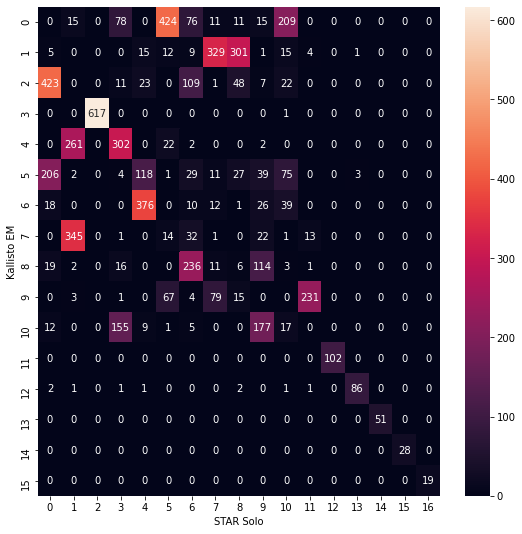

In [87]:
plot_confusion('leiden', common_anndata, 'STAR Solo', 'Kallisto EM')

## Leiden Alevin vs Kallisto confusion matrix

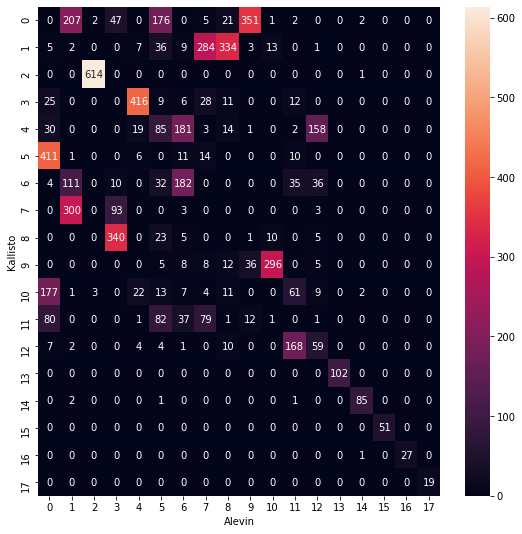

In [88]:
plot_confusion('leiden', common_anndata, 'Alevin', 'Kallisto')

## Leiden Alevin vs Kallisto EM confusion matrix

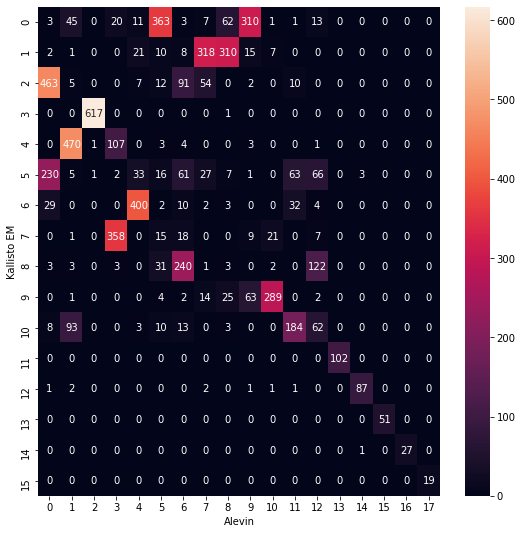

In [89]:
plot_confusion('leiden', common_anndata, 'Alevin', 'Kallisto EM')

## Leiden Kallisto vs Kallisto EM confusion matrix

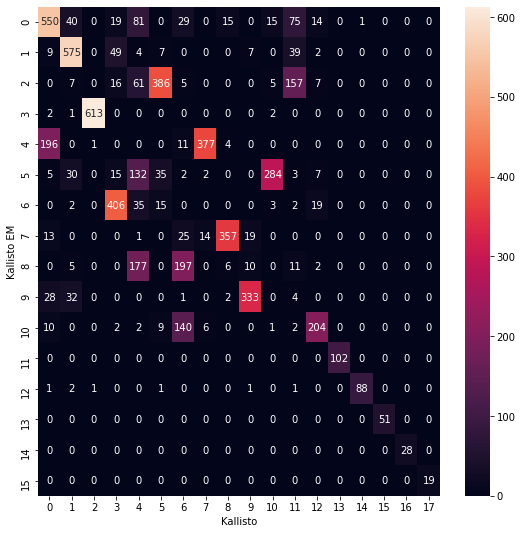

In [90]:
plot_confusion('leiden', common_anndata, 'Kallisto', 'Kallisto EM')

## Louvain Cellranger vs STAR Solo confusion matrix

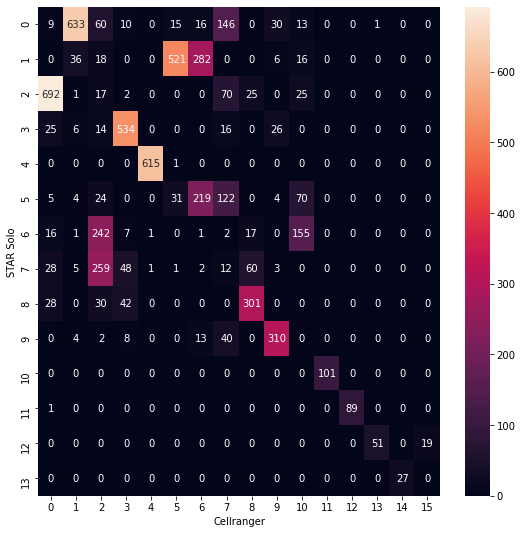

In [91]:
plot_confusion('louvain', common_anndata, 'Cellranger', 'STAR Solo')

## Louvain Cellranger vs Alevin confusion matrix

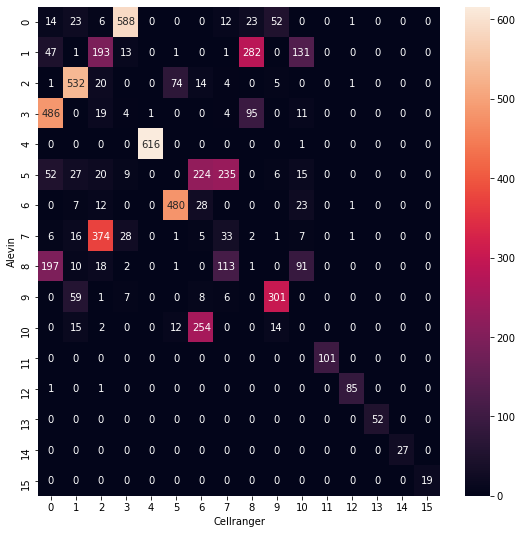

In [92]:
plot_confusion('louvain', common_anndata, 'Cellranger', 'Alevin')

## Louvain Cellranger vs Kallisto confusion matrix

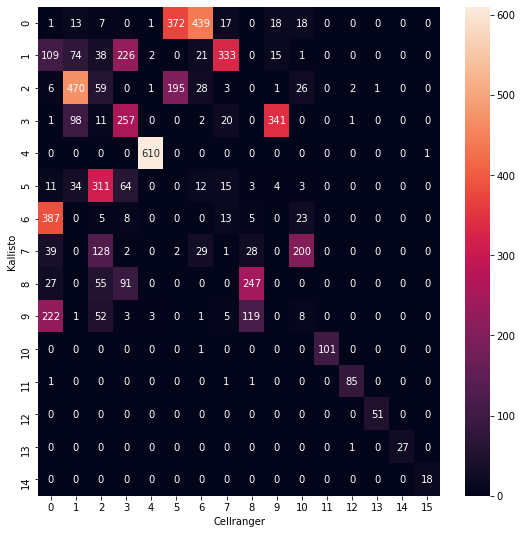

In [93]:
plot_confusion('louvain', common_anndata, 'Cellranger', 'Kallisto')

## Louvain Cellranger vs Kallisto EM confusion matrix

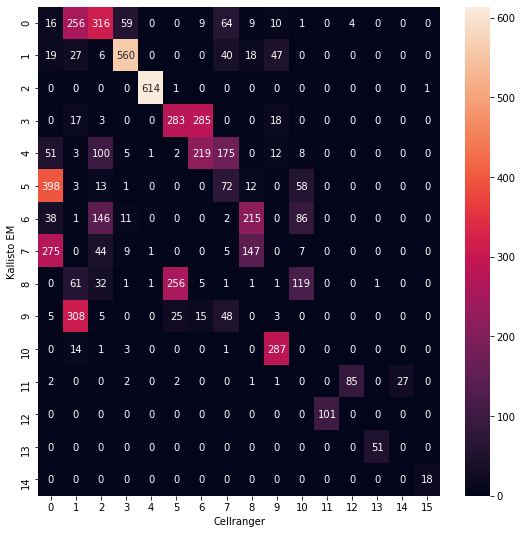

In [94]:
plot_confusion('louvain', common_anndata, 'Cellranger', 'Kallisto EM')

## Louvain STAR Solo vs Alevin confusion matrix

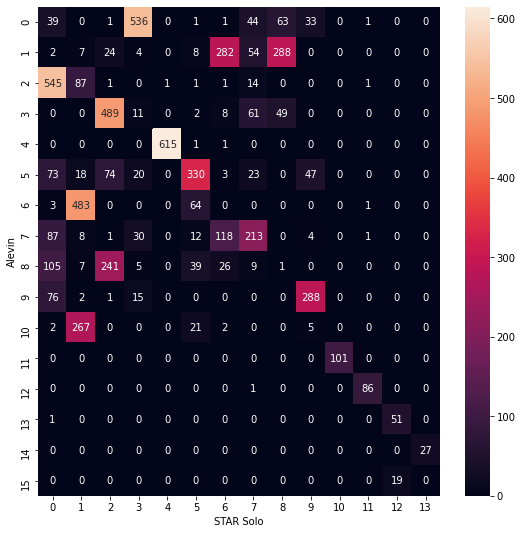

In [95]:
plot_confusion('louvain', common_anndata, 'STAR Solo', 'Alevin')

## Louvain STAR Solo vs Kallisto confusion matrix

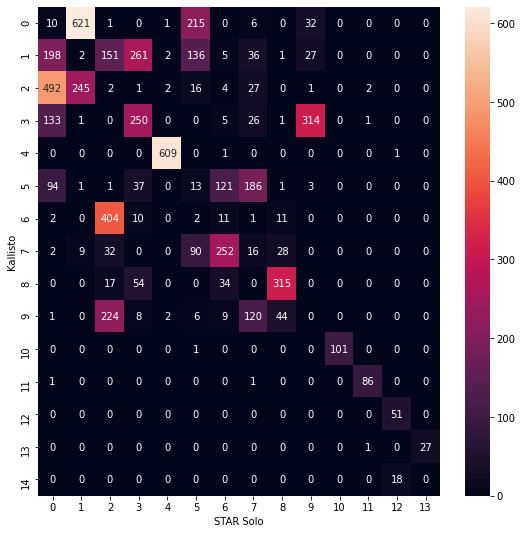

In [96]:
plot_confusion('louvain', common_anndata, 'STAR Solo', 'Kallisto')

## Louvain STAR Solo vs Kallisto EM confusion matrix

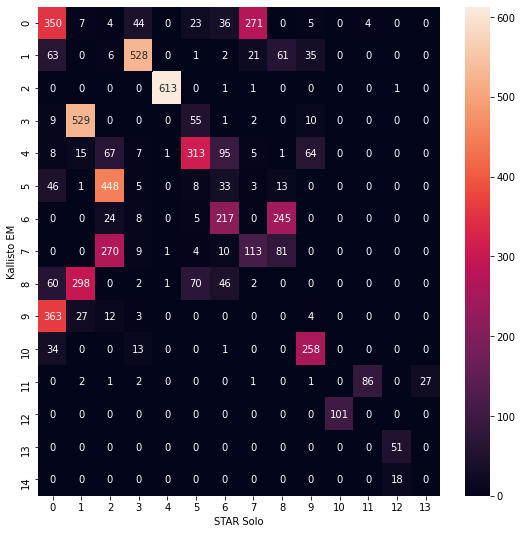

In [97]:
plot_confusion('louvain', common_anndata, 'STAR Solo', 'Kallisto EM')

## Louvain Alevin vs Kallisto confusion matrix

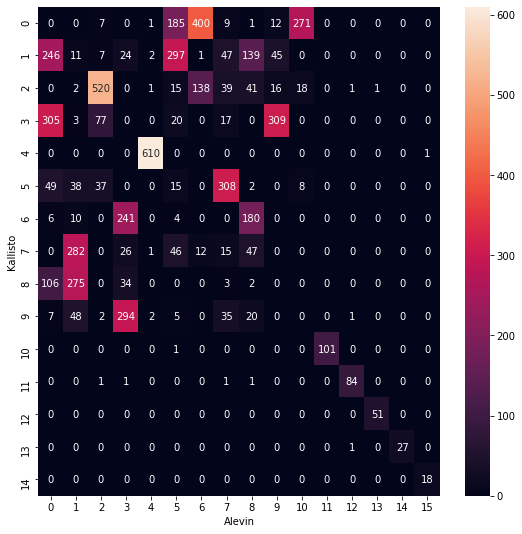

In [98]:
plot_confusion('louvain', common_anndata, 'Alevin', 'Kallisto')

## Louvain Alevin vs Kallisto EM confusion matrix

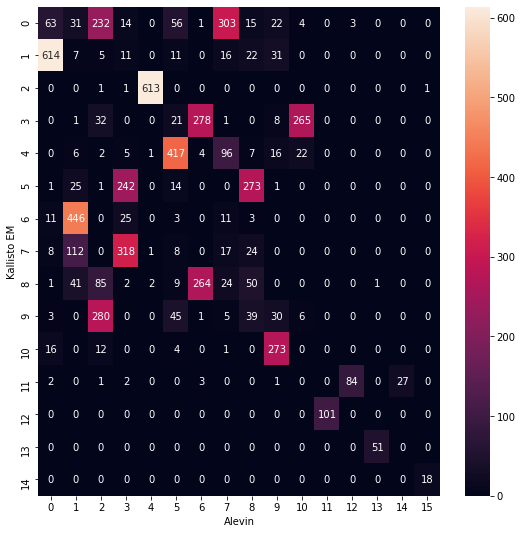

In [99]:
plot_confusion('louvain', common_anndata, 'Alevin', 'Kallisto EM')

## Louvain Kallisto vs Kallisto EM confusion matrix

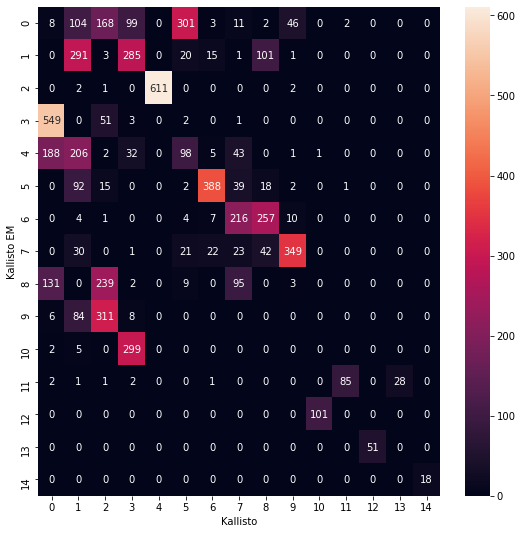

In [100]:
plot_confusion('louvain', common_anndata, 'Kallisto', 'Kallisto EM')

## Confusion between algorithms

In [101]:
def cross_alg_confusion(a, b):
    cm = {}
    
    for a_cluster in a.obs['leiden'].cat.categories:
        for b_cluster in b.obs['louvain'].cat.categories:
            cm.setdefault(a_cluster, {}).setdefault(b_cluster, 0)
            
    for a_barcode, a_cluster in a.obs['leiden'].iteritems():
        b_cluster = b.obs['louvain'][a_barcode]
        cm[a_cluster][b_cluster] += 1

    return pandas.DataFrame(cm, dtype=int)

def plot_cross_alg_confusion(common_anndata, a_label, b_label, title=None):
    cm = cross_alg_confusion(common_anndata[a_label], common_anndata[b_label])
    f = pyplot.figure(figsize=(9,9))
    ax = f.subplots()
    _ = seaborn.heatmap(cm, annot=True, fmt="d", ax=ax)
    ax.set_xlabel('leiden')
    ax.set_ylabel('louvain')
    if title is not None:
        ax.set_title(title)    
    

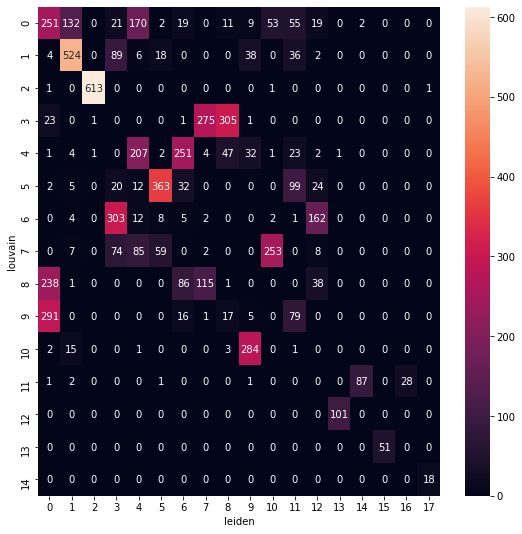

In [102]:
plot_cross_alg_confusion(common_anndata, 'Kallisto', 'Kallisto EM')

# How consistent are highly variable genes?

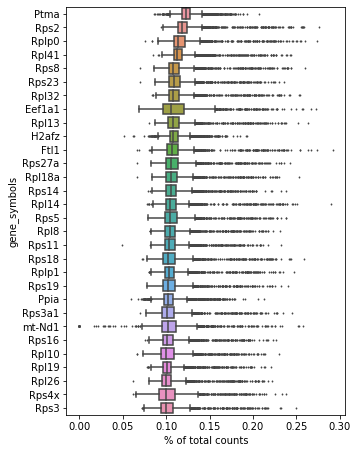

In [103]:
scanpy.pl.highest_expr_genes(cellr_common, gene_symbols='gene_symbols')

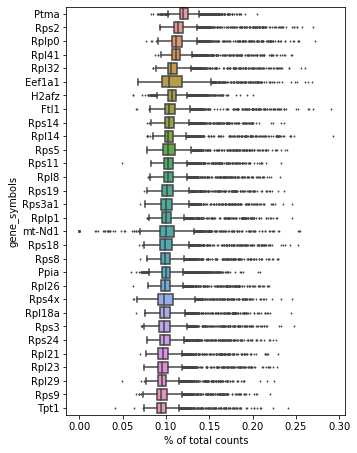

In [107]:
scanpy.pl.highest_expr_genes(solo_common, gene_symbols='gene_symbols')

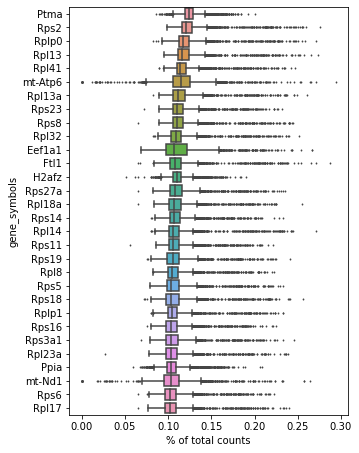

In [108]:
scanpy.pl.highest_expr_genes(alevin_common, gene_symbols='gene_symbols')

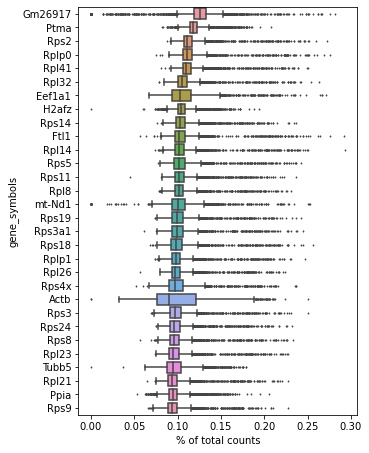

In [109]:
scanpy.pl.highest_expr_genes(kallisto_common, gene_symbols='gene_symbols')

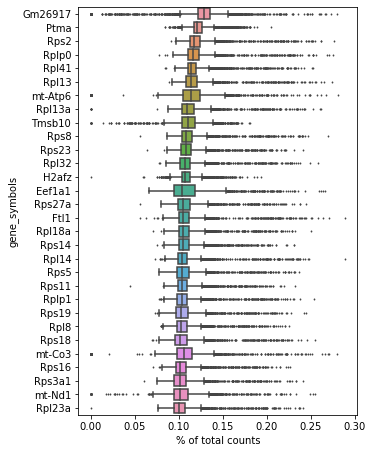

In [105]:
scanpy.pl.highest_expr_genes(kallisto_em_common, gene_symbols='gene_symbols')

In [ ]:
def get_highly_variable_set(adata):
    return set(adata.var[adata.var['highly_variable'] == True].index.values)

In [ ]:
upset_highly_variable = upsetplot.from_contents({
    'Cellranger': get_highly_variable_set(cellr_common),
    'STAR Solo': get_highly_variable_set(solo_common),
    'Alevin': get_highly_variable_set(alevin_common),
    'Kallisto': get_highly_variable_set(kallisto_common),
    'Kallisto EM': get_highly_variable_set(kallisto_em_common),
})

In [ ]:
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_highly_variable, fig=f, show_counts=True)

In [ ]:
idx = pandas.IndexSlice
kallistos = upset_highly_variable.loc[idx[False], idx[False], idx[False], idx[True], idx[True]]

In [ ]:
star_like = upset_highly_variable.loc[idx[True], idx[True], idx[True], idx[False], idx[False]]

In [ ]:
upset_common = upset_highly_variable.loc[idx[True], idx[True], idx[True], idx[True], idx[True]]

In [ ]:
kallistos['id'].values

In [ ]:
kallisto_common.var.loc[kallistos['id']]

In [ ]:
kallisto_common.var.loc[upset_common['id']]

In [ ]:
kallisto_common.var_names.isin(upset_common['id'])

In [ ]:
kallisto_common.var['highly_variable_for_all'] = kallisto_common.var_names.isin(upset_common['id'])

In [ ]:
kallisto_common.var_keys()

In [ ]:
kallisto_common

In [ ]:
scanpy.pl.violin(, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

# Todo

* Filter transcriptome bam file to common barcodes
  * WAITING on Alex adding CB tag to transcriptome BAM
* Run combined 10x transcriptome bam file through RSEM
* Compute correlations between sum of all the counts across the annotation axis and the population RSEM annotation
* Compute correlation between sum of counts between C1 cells and C1 population RSEM.
  * Waiting on run.

In [106]:
cellr_common

AnnData object with n_obs × n_vars = 6287 × 24839 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'